<a href="https://colab.research.google.com/github/weagan/MoE/blob/main/Mixture_of_Experts_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mixture-of-Experts (MoE) Training Notebook
# This notebook implements three variants: Base MoE, Sparse MoE, and CNN+MoE

Hands-on 2: Mixture of Experts (MoE) from Scratch

https://youtu.be/FfDPLzEY9Dw?si=e_qzWMTdlbecQL7H


In [1]:
# ============================================================================
# CELL 1: Install Dependencies
# ============================================================================
# Run this cell first to install required packages
!pip install torchmetrics matplotlib -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 19.7 MB/s eta 0:00:00


In [2]:
# ============================================================================
# CELL 2: Configuration File (config.py)
# ============================================================================
# Model hyperparameters
DATASET = 'SVHN'  # Options: 'SVHN', 'CIFAR100', 'CIFAR10', 'MNIST'
INPUT_DIM = 32 * 32 * 3 if DATASET in ['SVHN', 'CIFAR10', 'CIFAR100'] else 28 * 28
INPUT_CHANNELS = 3 if DATASET in ['SVHN', 'CIFAR10', 'CIFAR100'] else 1
NUM_CLASSES = 10 if DATASET in ['SVHN', 'CIFAR10'] else 100 if DATASET == 'CIFAR100' else 10
NUM_EXPERTS = 8
HIDDEN_DIM = 1024
OUTPUT_DIM = 1024
TOP_K = 2

# Training hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 2
NUM_GPUS = 1 # Set to 0 for CPU, 1 for single GPU, >1 for multiple GPUs

MODEL_TYPE = 'sparse'  # Choose which model to train: 'base', 'sparse', or 'cnn'

print(f"Configuration loaded for {DATASET} dataset")
print(f"Num Classes: {NUM_CLASSES}, Num Experts: {NUM_EXPERTS}, Top-K: {TOP_K}, GPUs: {NUM_GPUS}")
print(f"Model Type: {MODEL_TYPE}")

Configuration loaded for SVHN dataset
Num Classes: 10, Num Experts: 8, Top-K: 2, GPUs: 1
Model Type: sparse


In [3]:
# ============================================================================
# CELL 9: Data Loading
# ============================================================================
def get_data_loaders(dataset_name, batch_size):
    """Get data loaders for the specified dataset"""
    if dataset_name == 'CIFAR10':
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ])
        train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        val_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    elif dataset_name == 'CIFAR100':
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
        ])
        train_data = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
        val_data = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

    elif dataset_name == 'MNIST':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        val_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    elif dataset_name == 'SVHN':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970))
        ])
        train_data = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
        val_data = datasets.SVHN(root='./data', split='test', download=True, transform=transform)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

print("Data loading function defined successfully")

Data loading function defined successfully


In [4]:
# ============================================================================
# CELL 3: Import Libraries
# ============================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score
import csv
import matplotlib.pyplot as plt
from IPython.display import clear_output

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0+cu126
CUDA available: True
CUDA device: Tesla T4


In [5]:
# ============================================================================
# CELL 4: Base MoE Components
# ============================================================================
class GatingFunc(nn.Module):
    """Basic gating function for Base MoE"""
    def __init__(self, input_dim, num_experts):
        super(GatingFunc, self).__init__()
        self.fc = nn.Linear(input_dim, num_experts)

    def forward(self, x):
        return F.softmax(self.fc(x), dim=-1)


class GatingFuncSparse(nn.Module):
    """Sparse gating function with top-K routing"""
    def __init__(self, input_dim, num_experts, k=2):
        super(GatingFuncSparse, self).__init__()
        self.fc = nn.Linear(input_dim, num_experts)
        self.k = k

    def forward(self, x):
        logits = self.fc(x)
        topk_vals, topk_indices = torch.topk(logits, self.k, dim=-1)
        gate_weights = F.softmax(topk_vals, dim=-1)
        sparse_gate_weights = torch.zeros_like(logits).scatter(-1, topk_indices, gate_weights)
        return sparse_gate_weights


class Expert(nn.Module):
    """Expert network - small feed-forward network"""
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Expert, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

print("MoE components defined successfully")

MoE components defined successfully


In [6]:
# ============================================================================
# CELL 5: MoE Transformer Blocks
# ============================================================================
class TransformerBlockBaseMoE(nn.Module):
    """Basic MoE transformer block without sparsity"""
    def __init__(self, input_dim, num_experts, hidden_dim, output_dim):
        super(TransformerBlockBaseMoE, self).__init__()
        self.experts = nn.ModuleList([Expert(input_dim, hidden_dim, output_dim)
                                     for _ in range(num_experts)])
        self.gating_network = GatingFunc(input_dim, num_experts)
        self.layer_norm = nn.LayerNorm(output_dim)

    def forward(self, x):
        gate_weights = self.gating_network(x)
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=1)
        moe_output = (gate_weights.unsqueeze(-1) * expert_outputs).sum(dim=1)
        return self.layer_norm(moe_output + x)


class TransformerBlockSparseMoE(nn.Module):
    """Sparse MoE transformer block with load balancing"""
    def __init__(self, input_dim, num_experts, hidden_dim, output_dim, k=2):
        super(TransformerBlockSparseMoE, self).__init__()
        self.experts = nn.ModuleList([Expert(input_dim, hidden_dim, output_dim)
                                     for _ in range(num_experts)])
        self.gating_network = GatingFuncSparse(input_dim, num_experts, k)
        self.layer_norm = nn.LayerNorm(output_dim)

    def forward(self, x):
        gate_weights = self.gating_network(x)
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=1)
        moe_output = (gate_weights.unsqueeze(-1) * expert_outputs).sum(dim=1)

        D_i = gate_weights.mean(dim=0)
        load_balancing_loss = (D_i * torch.log(D_i + 1e-8)).sum()

        return self.layer_norm(moe_output + x), load_balancing_loss

print("Transformer blocks defined successfully")

Transformer blocks defined successfully


In [7]:
# ============================================================================
# CELL 6: CNN Feature Extractor
# ============================================================================
class CNNFeatureExtractor(nn.Module):
    """CNN for extracting features from images"""
    def __init__(self, input_channels=3, feature_dim=256, input_size=32):
        super(CNNFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Calculate the flattened size dynamically based on input_size
        # Simulate a forward pass to determine the dimensions
        dummy_input = torch.zeros(1, input_channels, input_size, input_size)
        x = F.relu(F.max_pool2d(self.conv1(dummy_input), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        flattened_size = x.view(x.size(0), -1).size(1)

        self.fc = nn.Linear(flattened_size, feature_dim)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(x.size(0), -1)
        return self.fc(x)

print("CNN feature extractor defined successfully")

CNN feature extractor defined successfully


In [8]:
# ============================================================================
# CELL 7: Complete Models
# ============================================================================
class BaseMoETransformer(nn.Module):
    """Base MoE model without sparsity"""
    def __init__(self, input_dim, num_classes, num_experts, hidden_dim, output_dim):
        super(BaseMoETransformer, self).__init__()
        self.input_projection = nn.Linear(input_dim, output_dim)
        self.transformer_block = TransformerBlockBaseMoE(output_dim, num_experts,
                                                         hidden_dim, output_dim)
        self.fc_out = nn.Linear(output_dim, num_classes)

    def forward(self, x):
        x = self.input_projection(x)
        x = self.transformer_block(x)
        return self.fc_out(x)


class SparseMoETransformer(nn.Module):
    """Sparse MoE model with top-K routing"""
    def __init__(self, input_dim, num_classes, num_experts, hidden_dim, output_dim, k=2):
        super(SparseMoETransformer, self).__init__()
        self.input_projection = nn.Linear(input_dim, output_dim)
        self.transformer_block = TransformerBlockSparseMoE(output_dim, num_experts,
                                                           hidden_dim, output_dim, k)
        self.fc_out = nn.Linear(output_dim, num_classes)

    def forward(self, x):
        x = self.input_projection(x)
        x, load_balancing_loss = self.transformer_block(x)
        return self.fc_out(x), load_balancing_loss


class CNNMoETransformer(nn.Module):
    """CNN + Sparse MoE hybrid model"""
    def __init__(self, input_channels, num_classes, num_experts, hidden_dim, output_dim, k=2):
        super(CNNMoETransformer, self).__init__()
        # Determine input_size based on DATASET global variable
        if DATASET in ['SVHN', 'CIFAR10', 'CIFAR100']:
            input_size = 32
        elif DATASET == 'MNIST':
            input_size = 28
        else:
            raise ValueError(f"Unsupported dataset: {DATASET}")

        self.feature_extractor = CNNFeatureExtractor(input_channels=input_channels,
                                                     feature_dim=output_dim,
                                                     input_size=input_size)
        self.transformer_block = TransformerBlockSparseMoE(output_dim, num_experts,
                                                           hidden_dim, output_dim, k)
        self.fc_out = nn.Linear(output_dim, num_classes)

    def forward(self, x):
        x = self.feature_extractor(x)
        x, load_balancing_loss = self.transformer_block(x)
        return self.fc_out(x), load_balancing_loss

print("All models defined successfully")

All models defined successfully


**Reasoning**:
The next step is to run `cell 6879c829` to ensure the modified `Trainer` class, which handles DataParallel loss correctly, is loaded into the kernel.



In [9]:
# ============================================================================
# CELL 8: Trainer Class
# ============================================================================
class Trainer:
    """Universal trainer for all MoE variants"""
    def __init__(self, model, train_loader, val_loader, criterion, optimizer,
                 epochs, device='cpu', save_path='metrics.csv', alpha=0.001,
                 use_load_balancing=False, use_cnn=False):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.epochs = epochs
        self.device = device
        self.save_path = save_path
        self.alpha = alpha
        self.use_load_balancing = use_load_balancing
        self.use_cnn = use_cnn

        self.accuracy = Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)
        self.precision = Precision(task="multiclass", num_classes=NUM_CLASSES,
                                  average='macro').to(device)
        self.recall = Recall(task="multiclass", num_classes=NUM_CLASSES,
                           average='macro').to(device)
        self.f1 = F1Score(task="multiclass", num_classes=NUM_CLASSES,
                         average='macro').to(device)
        self.metrics_history = []

    def train(self):
        for epoch in range(self.epochs):
            self.model.train()
            running_loss = 0.0
            total_acc, total_prec, total_recall, total_f1 = 0.0, 0.0, 0.0, 0.0

            for images, labels in self.train_loader:
                if not self.use_cnn:
                    images = images.view(images.size(0), -1)
                images = images.to(self.device)
                labels = labels.to(self.device)

                self.optimizer.zero_grad()

                if self.use_load_balancing:
                    outputs, load_balancing_loss = self.model(images)
                    # If using DataParallel, load_balancing_loss will be a tuple/list of losses from each GPU
                    if isinstance(self.model, nn.DataParallel):
                        load_balancing_loss = load_balancing_loss.mean() # Average the loss across GPUs
                    loss = self.criterion(outputs, labels) + self.alpha * load_balancing_loss
                else:
                    outputs = self.model(images)
                    loss = self.criterion(outputs, labels)

                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                total_acc += self.accuracy(outputs, labels)
                total_prec += self.precision(outputs, labels)
                total_recall += self.recall(outputs, labels)
                total_f1 += self.f1(outputs, labels)

            epoch_loss = running_loss / len(self.train_loader)
            epoch_acc = total_acc / len(self.train_loader)
            epoch_prec = total_prec / len(self.train_loader)
            epoch_recall = total_recall / len(self.train_loader)
            epoch_f1 = total_f1 / len(self.train_loader)

            # Validation
            self.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for images, labels in self.val_loader:
                    if not self.use_cnn:
                        images = images.view(images.size(0), -1)
                    images = images.to(self.device)
                    labels = labels.to(self.device)

                    if self.use_load_balancing:
                        outputs, _ = self.model(images)
                    else:
                        outputs = self.model(images)

                    loss = self.criterion(outputs, labels)
                    val_loss += loss.item()

            val_loss /= len(self.val_loader)

            self.metrics_history.append({
                'epoch': epoch + 1,
                'train_loss': epoch_loss,
                'val_loss': val_loss,
                'accuracy': epoch_acc.item(),
                'precision': epoch_prec.item(),
                'recall': epoch_recall.item(),
                'f1_score': epoch_f1.item()
            })

            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{self.epochs}], Train Loss: {epoch_loss:.4f}, "
                      f"Val Loss: {val_loss:.4f}, Acc: {epoch_acc:.4f}, F1: {epoch_f1:.4f}")

        print("Training complete!")
        self.save_metrics()

    def save_metrics(self):
        with open(self.save_path, mode='w', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=self.metrics_history[0].keys())
            writer.writeheader()
            writer.writerows(self.metrics_history)
        print(f"Metrics saved to {self.save_path}")

print("Trainer class defined successfully")

Trainer class defined successfully


In [10]:
# ============================================================================
# CELL 10: Training - Choose Your Model
# ============================================================================
# Device setup
if NUM_GPUS > 0 and torch.cuda.is_available():
    device = 'cuda'
    if NUM_GPUS > 1 and torch.cuda.device_count() >= NUM_GPUS:
        device_ids = list(range(NUM_GPUS))
        print(f"Using {NUM_GPUS} GPUs: {device_ids}")
    elif NUM_GPUS == 1:
        print("Using single GPU")
        device_ids = [0] # Only use the first GPU
    else:
        print(f"Requested {NUM_GPUS} GPUs, but only {torch.cuda.device_count()} available or request invalid. Using CPU.")
        device = 'cpu'
        device_ids = []
else:
    device = 'cpu'
    device_ids = []
    print("Using CPU")

print(f"Training will run on device: {device}")

# Load data
train_loader, val_loader = get_data_loaders(DATASET, BATCH_SIZE)
print(f"Data loaded: {len(train_loader)} training batches, {len(val_loader)} validation batches")

# Create model based on type
if MODEL_TYPE == 'base':
    model = BaseMoETransformer(
        input_dim=INPUT_DIM,
        num_classes=NUM_CLASSES,
        num_experts=NUM_EXPERTS,
        hidden_dim=HIDDEN_DIM,
        output_dim=OUTPUT_DIM
    )
    save_path = 'metrics_base_moe.csv'
    use_load_balancing = False
    use_cnn = False
    print("Training Base MoE model")

elif MODEL_TYPE == 'sparse':
    model = SparseMoETransformer(
        input_dim=INPUT_DIM,
        num_classes=NUM_CLASSES,
        num_experts=NUM_EXPERTS,
        hidden_dim=HIDDEN_DIM,
        output_dim=OUTPUT_DIM,
        k=TOP_K
    )
    save_path = 'metrics_sparse_moe.csv'
    use_load_balancing = True
    use_cnn = False
    print("Training Sparse MoE model")

else:  # cnn
    model = CNNMoETransformer(
        input_channels=INPUT_CHANNELS,
        num_classes=NUM_CLASSES,
        num_experts=NUM_EXPERTS,
        hidden_dim=HIDDEN_DIM,
        output_dim=OUTPUT_DIM,
        k=TOP_K
    )
    save_path = 'metrics_cnn_moe.csv'
    use_load_balancing = True
    use_cnn = True
    print("Training CNN + MoE model")

# Wrap model for DataParallel if multiple GPUs are available and requested
if device == 'cuda' and NUM_GPUS > 1 and torch.cuda.device_count() >= NUM_GPUS:
    print(f"Wrapping model in DataParallel for {len(device_ids)} GPUs.")
    model = nn.DataParallel(model, device_ids=device_ids)
    # When using DataParallel, the model's actual device is handled internally.
    # So, we don't explicitly call .to(device) on the DataParallel wrapper itself
    # but we will send the model to the primary device before wrapping
    # if the model was not already moved during its creation.
    # However, the Trainer expects the model to be on the target device already
    # or will move it, which DataParallel will handle. So, the base model needs to be on device[0]
    model.module.to(f'cuda:{device_ids[0]}') # Move the base model to the primary device for DataParallel
else:
    model.to(device)


# Initialize trainer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=device,
    save_path=save_path,
    alpha=0.001,
    use_load_balancing=use_load_balancing,
    use_cnn=use_cnn
)

# Start training
print(f"\nStarting training for {EPOCHS} epochs...")
trainer.train()

Using single GPU
Training will run on device: cuda


100%|██████████| 182M/182M [00:02<00:00, 61.2MB/s]
100%|██████████| 64.3M/64.3M [00:01<00:00, 37.3MB/s]


Data loaded: 1145 training batches, 407 validation batches
Training Sparse MoE model

Starting training for 2 epochs...
Training complete!
Metrics saved to metrics_sparse_moe.csv


# ============================================================================
# CELL 12: Inference Run
# ============================================================================

Actual Labels: [5 2 1 0 6]
Predicted Labels: [5 2 1 1 6]


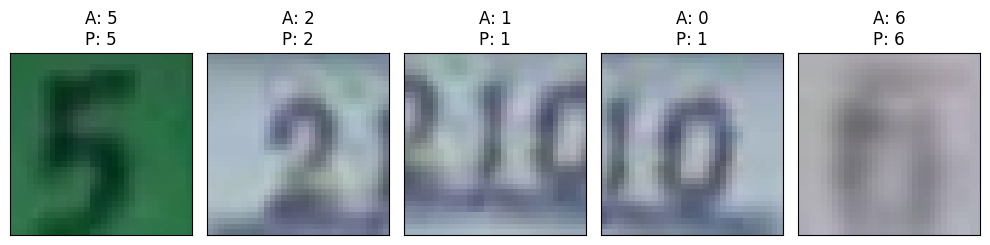

Inference run completed for sparse model on SVHN dataset.


In [11]:
import numpy as np
model.eval()

# Get a batch of validation images and labels
dataiter_val = iter(val_loader)
images_val, labels_val = next(dataiter_val)

# Determine the actual underlying model, unwrapping from DataParallel if necessary
actual_model = model.module if isinstance(model, nn.DataParallel) else model

# Determine if the current model is a CNN-based model
is_cnn_model_active = isinstance(actual_model, CNNMoETransformer)

# Move images and labels to device and format input correctly
if not is_cnn_model_active:
    images_val_processed = images_val.view(images_val.size(0), -1).to(device)
else:
    images_val_processed = images_val.to(device)

labels_val = labels_val.to(device)

# Perform inference
with torch.no_grad():
    # Check if the model has a load_balancing_loss in its forward method
    # This is typical for SparseMoETransformer and CNNMoETransformer
    if isinstance(actual_model, (SparseMoETransformer, CNNMoETransformer)):
        outputs, _ = model(images_val_processed)
    else:
        outputs = model(images_val_processed)

# Get predicted class indices
_, predicted = torch.max(outputs.data, 1)

print(f"Actual Labels: {labels_val[:5].cpu().numpy()}")
print(f"Predicted Labels: {predicted[:5].cpu().numpy()}")

# Display the first 5 images with their actual and predicted labels
fig = plt.figure(figsize=(10, 5))
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
    # Unnormalize for display if a specific unnormalize function exists or for SVHN
    if DATASET == 'SVHN':
        img = images_val[i].cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.4377, 0.4438, 0.4728])
        std = np.array([0.1980, 0.2010, 0.1970])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        ax.imshow(img)
    elif DATASET in ['CIFAR10', 'CIFAR100']:
        img = images_val[i].cpu().numpy().transpose((1, 2, 0))
        img = np.clip(img, 0, 1) # Simple clip if no unnormalization is specific
        ax.imshow(img)
    elif DATASET == 'MNIST':
        img = images_val[i].squeeze().cpu().numpy()
        ax.imshow(img, cmap='gray')

    ax.set_title(f"A: {labels_val[i].item()}\nP: {predicted[i].item()}")
plt.tight_layout()
plt.show()

print(f"Inference run completed for {MODEL_TYPE} model on {DATASET} dataset.")

# ============================================================================
# CELL 13: Model Comparison Metrics
# ============================================================================

In [12]:
import time

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def estimate_activated_parameters(model, model_type, num_experts, top_k):
    if model_type == 'base':
        return count_parameters(model)
    elif model_type == 'sparse' or model_type == 'cnn':
        # Sum parameters of shared layers (input_projection, fc_out, layer_norm)
        # and gating network
        shared_params = 0
        if hasattr(model, 'input_projection'):
            shared_params += sum(p.numel() for p in model.input_projection.parameters() if p.requires_grad)
        if hasattr(model, 'fc_out'):
            shared_params += sum(p.numel() for p in model.fc_out.parameters() if p.requires_grad)

        # TransformerBlockSparseMoE contains gating_network and layer_norm
        if hasattr(model, 'transformer_block'):
            if hasattr(model.transformer_block, 'gating_network'):
                shared_params += sum(p.numel() for p in model.transformer_block.gating_network.parameters() if p.requires_grad)
            if hasattr(model.transformer_block, 'layer_norm'):
                shared_params += sum(p.numel() for p in model.transformer_block.layer_norm.parameters() if p.requires_grad)

        # Add parameters for K active experts
        expert_params = 0
        if hasattr(model, 'transformer_block') and hasattr(model.transformer_block, 'experts') and len(model.transformer_block.experts) > 0:
            # Assuming all experts have the same structure, count one and multiply by K
            expert_params = sum(p.numel() for p in model.transformer_block.experts[0].parameters() if p.requires_grad) * top_k

        cnn_params = 0
        if model_type == 'cnn' and hasattr(model, 'feature_extractor'):
            cnn_params = sum(p.numel() for p in model.feature_extractor.parameters() if p.requires_grad)

        return shared_params + expert_params + cnn_params
    return 0

def measure_inference_speed(model, sample_input, device, num_runs=100):
    model.eval()
    model.to(device)
    sample_input = sample_input.to(device)

    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)

    # Warm-up runs
    for _ in range(10):
        if isinstance(model, (SparseMoETransformer, CNNMoETransformer)):
            _ = model(sample_input)
        else:
            _ = model(sample_input)

    timings = []
    with torch.no_grad():
        for _ in range(num_runs):
            start_event.record()
            if isinstance(model, (SparseMoETransformer, CNNMoETransformer)):
                _ = model(sample_input)
            else:
                _ = model(sample_input)
            end_event.record()
            torch.cuda.synchronize() # Wait for the events to complete
            timings.append(start_event.elapsed_time(end_event))

    mean_inference_time = sum(timings) / num_runs
    return mean_inference_time # in milliseconds


print("Comparison functions defined.")

Comparison functions defined.


In [13]:
model_types = ['base', 'sparse', 'cnn']
results = {}

# Get a sample input for inference speed measurement
train_loader, _ = get_data_loaders(DATASET, BATCH_SIZE)
images, _ = next(iter(train_loader))

device = 'cuda' if torch.cuda.is_available() else 'cpu'

original_input_dim = INPUT_DIM
original_input_channels = INPUT_CHANNELS

for m_type in model_types:
    print(f"\n--- Comparing {m_type.upper()} MoE Model ---")
    current_input_dim = original_input_dim
    current_input_channels = original_input_channels
    use_cnn_model = False
    use_load_balancing_model = False

    # The input_size for CNNFeatureExtractor is determined by the DATASET global variable
    # in the CNNMoETransformer's __init__ method. So, we don't need to pass it here.
    if m_type == 'base':
        model = BaseMoETransformer(
            input_dim=current_input_dim,
            num_classes=NUM_CLASSES,
            num_experts=NUM_EXPERTS,
            hidden_dim=HIDDEN_DIM,
            output_dim=OUTPUT_DIM
        ).to(device)
        sample_input = images.view(images.size(0), -1)
    elif m_type == 'sparse':
        model = SparseMoETransformer(
            input_dim=current_input_dim,
            num_classes=NUM_CLASSES,
            num_experts=NUM_EXPERTS,
            hidden_dim=HIDDEN_DIM,
            output_dim=OUTPUT_DIM,
            k=TOP_K
        ).to(device)
        use_load_balancing_model = True
        sample_input = images.view(images.size(0), -1)
    else: # cnn
        model = CNNMoETransformer(
            input_channels=current_input_channels,
            num_classes=NUM_CLASSES,
            num_experts=NUM_EXPERTS,
            hidden_dim=HIDDEN_DIM,
            output_dim=OUTPUT_DIM,
            k=TOP_K
        ).to(device)
        use_load_balancing_model = True
        use_cnn_model = True
        sample_input = images

    total_params = count_parameters(model)
    activated_params = estimate_activated_parameters(model, m_type, NUM_EXPERTS, TOP_K)
    inference_speed_ms = measure_inference_speed(model, sample_input, device)

    results[m_type] = {
        'total_params': total_params,
        'activated_params': activated_params,
        'inference_speed_ms': inference_speed_ms
    }

    print(f"Total Parameters: {total_params:,}")
    print(f"Activated Parameters (per inference): {activated_params:,}")
    print(f"Inference Speed (per batch, ms): {inference_speed_ms:.4f}")

print("\n--- Comparison Summary ---")
for m_type, metrics in results.items():
    print(f"\nModel Type: {m_type.upper()}")
    print(f"  Total Parameters: {metrics['total_params']:,}")
    print(f"  Activated Parameters (per inference): {metrics['activated_params']:,}")
    print(f"  Inference Speed (per batch, ms): {metrics['inference_speed_ms']:.4f}")



--- Comparing BASE MoE Model ---
Total Parameters: 19,960,850
Activated Parameters (per inference): 19,960,850
Inference Speed (per batch, ms): 1.9443

--- Comparing SPARSE MoE Model ---
Total Parameters: 19,960,850
Activated Parameters (per inference): 7,365,650
Inference Speed (per batch, ms): 1.7066

--- Comparing CNN MoE Model ---
Total Parameters: 19,005,522
Activated Parameters (per inference): 6,410,322
Inference Speed (per batch, ms): 2.1988

--- Comparison Summary ---

Model Type: BASE
  Total Parameters: 19,960,850
  Activated Parameters (per inference): 19,960,850
  Inference Speed (per batch, ms): 1.9443

Model Type: SPARSE
  Total Parameters: 19,960,850
  Activated Parameters (per inference): 7,365,650
  Inference Speed (per batch, ms): 1.7066

Model Type: CNN
  Total Parameters: 19,005,522
  Activated Parameters (per inference): 6,410,322
  Inference Speed (per batch, ms): 2.1988


Plot saved to ./metrics_sparse_moe.png


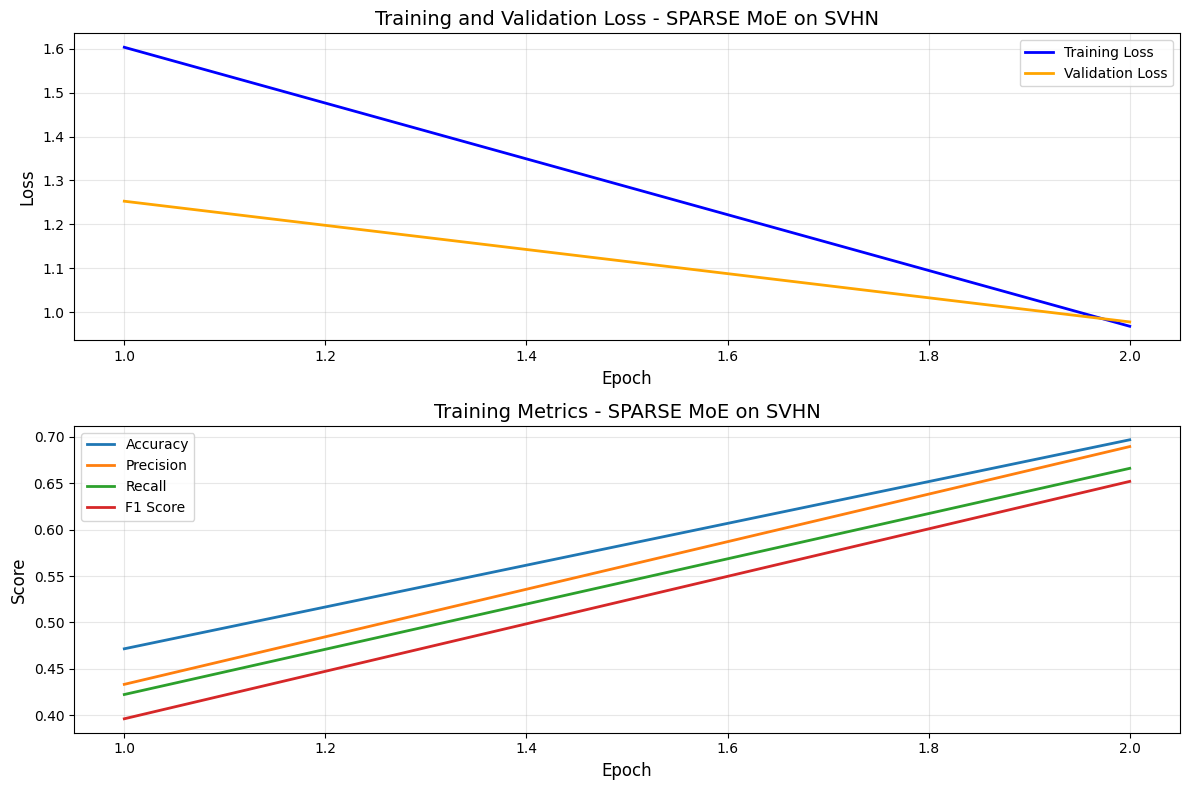


Final Results:
Training Loss: 0.9686
Validation Loss: 0.9785
Accuracy: 0.6968
Precision: 0.6895
Recall: 0.6660
F1 Score: 0.6519


In [14]:
# ============================================================================
# CELL 11: Plot Results
# ============================================================================
import matplotlib.pyplot as plt
import csv

def plot_metrics(csv_path, title_suffix=""):
    """Load and plot training metrics"""
    epochs, train_loss, val_loss = [], [], []
    accuracy, precision, recall, f1_score = [], [], [], []

    with open(csv_path, mode='r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            epochs.append(int(row['epoch']))
            train_loss.append(float(row['train_loss']))
            val_loss.append(float(row['val_loss']))
            accuracy.append(float(row['accuracy']))
            precision.append(float(row['precision']))
            recall.append(float(row['recall']))
            f1_score.append(float(row['f1_score']))

    plt.figure(figsize=(12, 8))

    # Loss plot
    plt.subplot(2, 1, 1)
    plt.plot(epochs, train_loss, label='Training Loss', color='blue', linewidth=2)
    plt.plot(epochs, val_loss, label='Validation Loss', color='orange', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title(f'Training and Validation Loss {title_suffix}', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    # Metrics plot
    plt.subplot(2, 1, 2)
    plt.plot(epochs, accuracy, label='Accuracy', linewidth=2)
    plt.plot(epochs, precision, label='Precision', linewidth=2)
    plt.plot(epochs, recall, label='Recall', linewidth=2)
    plt.plot(epochs, f1_score, label='F1 Score', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title(f'Training Metrics {title_suffix}', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    # The save_path for the image should be derived from the csv_path, not hardcoded.
    image_save_path = csv_path.replace('.csv', '.png')
    plt.savefig(image_save_path, dpi=300, bbox_inches='tight')
    print(f"Plot saved to {image_save_path}")
    plt.show()

    # Print final metrics
    print(f"\nFinal Results:")
    print(f"Training Loss: {train_loss[-1]:.4f}")
    print(f"Validation Loss: {val_loss[-1]:.4f}")
    print(f"Accuracy: {accuracy[-1]:.4f}")
    print(f"Precision: {precision[-1]:.4f}")
    print(f"Recall: {recall[-1]:.4f}")
    print(f"F1 Score: {f1_score[-1]:.4f}")

# Define MODEL_TYPE and DATASET from previous cells' execution for plot title
# The actual CSV file name is determined by the training cell (e.g., metrics_cnn_moe.csv)
# Assuming MODEL_TYPE and DATASET from the global kernel state

# Dynamically set save_path based on MODEL_TYPE from the training cell's logic
if 'MODEL_TYPE' in globals():
    if globals()['MODEL_TYPE'] == 'base':
        csv_file_name = 'metrics_base_moe.csv'
    elif globals()['MODEL_TYPE'] == 'sparse':
        csv_file_name = 'metrics_sparse_moe.csv'
    else: # 'cnn'
        csv_file_name = 'metrics_cnn_moe.csv'

    # The CSV file should be in the root content directory after running the notebook's training cells
    csv_path_to_load = './' + csv_file_name

    # Plot the results
    plot_metrics(csv_path_to_load, f"- {globals()['MODEL_TYPE'].upper()} MoE on {globals()['DATASET']}")
else:
    print("MODEL_TYPE or DATASET not defined. Please run the configuration and training cells first.")


### Displaying Sample Images from the Dataset

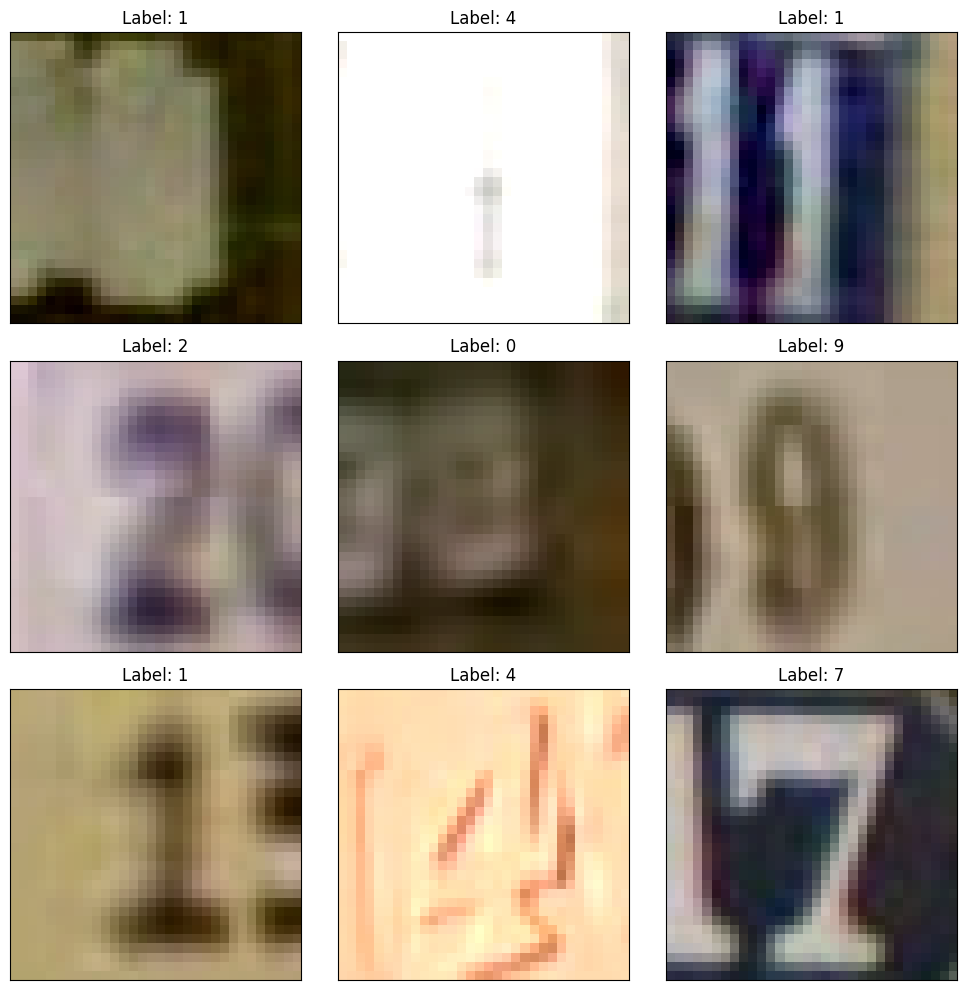

Displaying 9 sample images from the SVHN dataset.


In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming DATASET, train_loader, and val_loader are defined from previous cells
# Get a batch of training images and labels
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Function to unnormalize images for CIFAR100
def unnormalize_cifar100(img):
    mean = np.array([0.5071, 0.4867, 0.4408])
    std = np.array([0.2675, 0.2565, 0.2761])
    img = img.numpy().transpose((1, 2, 0))  # Convert from Tensor image (C, H, W) to (H, W, C)
    img = std * img + mean
    img = np.clip(img, 0, 1) # Clip values to [0, 1] range
    return img

# Get class names if available, otherwise just use label numbers
# For CIFAR100, we'd ideally load class names, but for a quick sample,
# we'll just show the integer labels.
# If a dataset like CIFAR100 has specific class names that are loaded,
# you could adapt this to fetch them.

# Display 9 sample images
fig = plt.figure(figsize=(10, 10))
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(unnormalize_cifar100(images[i]))
    ax.set_title(f"Label: {labels[i].item()}")
plt.tight_layout()
plt.show()
print(f"Displaying 9 sample images from the {DATASET} dataset.")